<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Signal-construction-&amp;-testing" data-toc-modified-id="Signal-construction-&amp;-testing-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Signal construction &amp; testing</a></span><ul class="toc-item"><li><span><a href="#Part-(a)" data-toc-modified-id="Part-(a)-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Part (a)</a></span></li><li><span><a href="#Part-(b)" data-toc-modified-id="Part-(b)-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Part (b)</a></span></li><li><span><a href="#Part-(c)" data-toc-modified-id="Part-(c)-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Part (c)</a></span></li><li><span><a href="#Part-(d)" data-toc-modified-id="Part-(d)-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Part (d)</a></span><ul class="toc-item"><li><span><a href="#(d)-i)" data-toc-modified-id="(d)-i)-4.4.1"><span class="toc-item-num">4.4.1&nbsp;&nbsp;</span>(d) i)</a></span></li><li><span><a href="#(d)-ii)" data-toc-modified-id="(d)-ii)-4.4.2"><span class="toc-item-num">4.4.2&nbsp;&nbsp;</span>(d) ii)</a></span></li></ul></li><li><span><a href="#Part-(e)" data-toc-modified-id="Part-(e)-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Part (e)</a></span></li><li><span><a href="#Part-(f)" data-toc-modified-id="Part-(f)-4.6"><span class="toc-item-num">4.6&nbsp;&nbsp;</span>Part (f)</a></span></li></ul></li></ul></div>

# Signal construction & testing

This question is an adaptation of the MIT paper *“Crowded Trades: Implications for Sector Rotation and Factor Timing”* that seeks to construct quantitative signals that can detect stock market bubbles. The `sector_data.csv` file contains daily price and market capitalization for 9 exchange traded funds (ETFs), each of which represents a basket of stocks in a given sector, along with the price-to-book-ratio for these underlying sectors. Note that the
data set includes only *trading days* (i.e. it excludes any weekends or holidays on which stock exchanges are closed). Aside from the leading `NA`s in the `rel_norm_price_to_book` column, you may assume that there are no missing dates nor values in the provided data set.

## Part (a)

i) Reshape the mkt price and mkt cap columns into $N × M$ matrices $\mathbf{X}$ and $\mathbf{Z}$ respectively, where $N$ is the number of trading days, and $M$ is the number of sectors

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from sklearn.decomposition import PCA

In [2]:
sector_data = pd.read_csv('data/task4/sector_data.csv')
sector_data['sector'].unique()

array(['Materials', 'Energy', 'Financials', 'Industrials',
       'Information technology', 'Consumer staples', 'Utilities',
       'Healthcare', 'Consumer discretionary'], dtype=object)

In [3]:
X = sector_data.pivot(index='date', columns='sector', values='mkt_price')
Z = sector_data.pivot(index='date', columns='sector', values='mkt_cap')
X.index = pd.to_datetime(X.index)
Z.index = pd.to_datetime(Z.index)
Z

sector,Consumer discretionary,Consumer staples,Energy,Financials,Healthcare,Industrials,Information technology,Materials,Utilities
date,,,,,,,,,
1998-12-22,17.8282,71.5500,48.8578,61.7781,38.7985,16.2969,153.8251,10.4141,50.7078
1998-12-23,17.9047,73.2796,49.8750,62.6892,39.6704,16.5813,157.5000,10.5235,50.4953
1998-12-24,18.2328,73.1533,49.6125,63.1031,39.9125,16.8000,156.9000,10.7657,51.4250
1998-12-28,18.0688,75.4250,49.3500,62.2750,39.3313,16.8875,157.3502,10.6719,51.1595
1998-12-29,18.4625,78.4642,49.8422,62.9375,40.2031,17.1282,157.8000,10.8672,52.0095
...,...,...,...,...,...,...,...,...,...
2020-10-05,16180.3000,13817.3000,8517.3300,17330.6000,24014.8000,12844.4000,34205.0000,4165.6500,11744.6000
2020-10-06,15903.0000,13727.3000,8369.5600,17524.4000,23638.6000,12645.2000,33478.5000,4202.5300,11738.6000
2020-10-07,16349.4000,13761.7000,8585.7700,17860.6000,23844.3000,12992.1000,34357.2000,4438.1400,11838.7000


Compute all sectors’ market capitlization-weighted daily returns in the form of the matrix $\dot{\mathbf{X}}$ given by

\begin{equation}
    \dot{X}_{nm} = \frac{X_{nm}-X_{n-1,m}}{X_{n-1,m}} \cdot \sqrt{\frac{Z_{nm}}{\sum_{j=1}^M Z_{nj}}}
\end{equation}

for all $n = 1, 2, ..., N$ and $m = 1, 2, ..., M$. Although the first row of matrix $\dot{\mathbf{X}}$ now consists of `NA`s, for simplicity we suppose that $\dot{\mathbf{X}}$ without these `NA`s is still of dimension $N × M$.

In [13]:
weights = Z.divide(Z.sum(axis=1), axis=0)
X_dot = X.pct_change(1) * weights
X_dot.dropna(inplace=True)
X_dot

sector,Consumer discretionary,Consumer staples,Energy,Financials,Healthcare,Industrials,Information technology,Materials,Utilities
date,,,,,,,,,
1998-12-23,0.000161,0.003702,0.002170,0.001932,0.001863,0.000605,0.007863,0.000231,-0.000442
1998-12-24,0.000696,-0.000263,-0.000544,0.000869,0.000508,0.000462,-0.001245,0.000516,0.001973
1998-12-28,-0.000338,-0.000906,-0.000543,-0.001701,-0.001192,0.000183,0.000940,-0.000193,-0.000550
1998-12-29,0.000825,0.003546,0.001019,0.001373,0.001827,0.000500,0.000925,0.000408,0.001772
1998-12-30,-0.000313,-0.001005,-0.001534,-0.000510,-0.000694,-0.000157,-0.001233,-0.000064,-0.000870
...,...,...,...,...,...,...,...,...,...
2020-10-05,0.001498,0.000649,0.001791,0.001997,0.003455,0.001448,0.005251,0.000558,0.001030
2020-10-06,-0.002084,-0.000633,-0.000883,-0.001256,-0.002220,-0.001090,-0.003673,-0.000374,0.000703
2020-10-07,0.002594,0.001028,0.000842,0.002079,0.003125,0.001992,0.004373,0.000793,0.000504


iii) Using the full historical data (for now), compute the centered returns matrix

\begin{equation}
\bar{\mathbf{X}} = \dot{\mathbf{X}} - \mathbf{1}\bar{x}^T
\end{equation}

where $\mathbf{1}\bar{x}^T$ is the outer product between an $N × 1$ column vector of all 1s and the mean return across all days for each sector, and finally the $M × M$ covariance matrix

\begin{equation}
\mathbf{C} = \frac{1}{N-1} \bar{\mathbf{X}}^T \bar{\mathbf{X}}
\end{equation}

clearly printing your output for $\mathbf{C}$.

In [15]:
X_bar = X_dot - X_dot.mean()
C = X_bar.cov() # = 1/(len(X_bar)-1) * X_bar.T.dot(X_bar)
C.shape

(9, 9)

iv) In a single sentence, explain why $\mathbf{C}$ is diagonalizable.

The Covariance matrix, $\mathbf{C}$, is symmetrical and therefore it is always diagonalizable.

## Part (b)

As $\mathbf{C}$ is diagonalizable, we can write $\mathbf{C} = \mathbf{QΛQ}^{−1}$ where $\mathbf{Q}$ is an orthogonal matrix whose columns are eigenvectors of $\mathbf{C}$, and $\mathbf{Λ}$ is a diagonal matrix whose entries are the corresponding eigenvalues $\mathbf{\lambda}_m$ for $m = 1, 2, ..., M$. Considering a subset of only the $K$ largest eigenvalues, define the *absorption ratio* of the $k$-th eigenvector by

\begin{equation}
AR_k = \frac{\lambda_k}{\sum_{m=1}^M \sigma_m^2}
\end{equation}

where $\sigma_m^2$ is the variance across all daily market-cap-weighted returns for the $m$-th sector. Intuitively, the absorption ratio measures the proportion of total variance (i.e. risk) in the returns across all sectors that can be explained (i.e. absorbed) by the unobserved factor represented by each eigenvector, and a higher $AR$ indicates that returns across the sector ETFs are more tightly coupled. Given $AR_k$, for each sector $m$ we can derive a centrality score

\begin{equation}
Cen_m = \frac{1}{\sum_{k=1}^K AR_k} \cdot \sum_{k=1}^K \left( AR_k \cdot \frac{|\mathbf{C}_m \cdot \mathbf{Q}_k|}{\sum_{i=1}^M |\mathbf{C}_i \cdot \mathbf{Q_k}|} \right)
\end{equation}

where $\mathbf{C}_m$ is the $m$-th column of covariance matrix computed in part (a)(iii), and $Q_k$ is the eigenvector that corresponds to the $k$-th eigenvalue (and so this dot product measures the exposure of sector $m$ to eigenvector $k$).

i) Using your matrix $\mathbf{C}$ from part (a)(iii) and $K = 2$, compute and clearly print the centrality score for each of the 9 sector ETFs. Note that the centrality scores should sum to $1$.

In [42]:
def get_centrality_score(C, K):
    C = np.array(C)
    model = PCA(n_components=K)
    model.fit(C)
    # Eigenvectors
    Q = model.components_  
    # The proportion of total risk
    AR = model.explained_variance_ratio_.reshape((-1, 1))
    frac = (np.abs(C.dot(Q.T)) /  np.abs(C.dot(Q.T)).sum()).sum(axis=1).reshape((-1, 1))
    return frac.dot(AR.T).sum(axis=1) / np.sum(AR)

In [47]:
scores = get_centrality_score(C, 2)
pd.DataFrame({'Sector': C.columns.values, 'Centrality Score': scores})

,Sector,Centrality Score
0,Consumer discretionary,0.039651
1,Consumer staples,0.039277
2,Energy,0.142753
3,Financials,0.302200
4,Healthcare,0.051666
5,Industrials,0.048210
6,Information technology,0.295341
7,Materials,0.037465
8,Utilities,0.043438


In [48]:
print(np.sum(scores)) # sanity check

0.9999999999999999


ii) Starting over again from the returns matrix $\dot{\mathbf{X}}$ in part (a)(ii) and **using only data in a moving window of 360 trading days**, compute the *daily* centrality score for all sectors using K = 2.

In [88]:
rolling_cov = X_dot.rolling(360).cov().dropna()
scores = []

for date in rolling_cov.index.get_level_values(0).unique():
    scores.append(get_centrality_score(rolling_cov.loc[date, :], K=2))

daily_centrality_score = pd.DataFrame(scores, index=rolling_cov.index.get_level_values(0).unique())
daily_centrality_score.columns = rolling_cov.columns

In [89]:
daily_centrality_score

sector,Consumer discretionary,Consumer staples,Energy,Financials,Healthcare,Industrials,Information technology,Materials,Utilities
date,,,,,,,,,
2000-05-30,0.025000,0.046164,0.021291,0.104949,0.032129,0.020750,0.722505,0.010654,0.016557
2000-05-31,0.024878,0.045607,0.020562,0.104546,0.031804,0.020650,0.724629,0.010679,0.016645
2000-06-01,0.024735,0.045181,0.019744,0.105607,0.031339,0.020515,0.725660,0.010625,0.016593
2000-06-02,0.024942,0.043192,0.017549,0.107349,0.031254,0.020383,0.728185,0.010830,0.016317
2000-06-05,0.024908,0.042951,0.017650,0.107538,0.031159,0.020362,0.728342,0.010836,0.016254
...,...,...,...,...,...,...,...,...,...
2020-10-05,0.092862,0.078699,0.101267,0.179745,0.131978,0.079790,0.225932,0.028473,0.081254
2020-10-06,0.092921,0.078699,0.101209,0.179637,0.132077,0.079779,0.226044,0.028475,0.081158
2020-10-07,0.093025,0.078674,0.101143,0.179496,0.132245,0.079839,0.226022,0.028499,0.081057


## Part (c) 

i) Compute the *standardized shift* of centrality scores by subtracting the prior 360-day average from the current day’s value and dividing this difference by the standard deviation over the prior 360-day period.

ii) Briefly explain the advantage of using this standardized shift instead of the level centrality scores.

In [108]:
standardized_shift = (daily_centrality_score - daily_centrality_score.rolling(360).mean()) / daily_centrality_score.rolling(360).std()
standardized_shift.dropna(inplace=True)

In [109]:
standardized_shift

sector,Consumer discretionary,Consumer staples,Energy,Financials,Healthcare,Industrials,Information technology,Materials,Utilities
date,,,,,,,,,
2001-11-06,2.199821,-1.026029,-0.823593,2.138229,-0.129089,-0.781920,-2.403958,3.156364,-1.062769
2001-11-07,2.351297,-1.031476,-0.628342,2.195759,-0.162998,-0.762540,-2.586101,3.113325,-1.068873
2001-11-08,2.385469,-1.011017,-0.756085,2.193216,-0.142545,-0.744808,-2.589501,3.055245,-1.058384
2001-11-09,2.453722,-0.993216,-0.817051,2.181248,-0.060747,-0.710082,-2.620758,3.067503,-1.065550
2001-11-12,2.422847,-1.065942,-1.056589,2.167338,-0.038373,-0.652154,-2.493837,2.961231,-1.045036
...,...,...,...,...,...,...,...,...,...
2020-10-05,-1.102820,0.956992,-0.911388,-1.099925,0.125305,-0.707044,0.081222,-0.302261,1.094264
2020-10-06,-1.092069,0.951676,-0.911596,-1.097574,0.147793,-0.704524,0.092519,-0.296522,1.085474
2020-10-07,-1.077441,0.945245,-0.912530,-1.096392,0.186876,-0.689545,0.082665,-0.279085,1.076603


The absolute level of centrality for an individual sector has little meaning and cannot be used to identify sector-specific trends. To observe its *change* in value over time, the standardized shift is calculated.

## Part (d)

The standardized shift of centrality scores (henceforth called *centrality shift*) measures the degree of crowding in trades on the respective sector ETFs. A high centrality shift could indicate a bubble run-up or a post-peak sell-off, but does not inherently distinguish between the two. This is where we need a measure of *relative value* in the form of relative normalized price-to-book ratio (pre-computed for you in the `rel_norm_price_to_book` column) as an overlay. The authors of the MIT paper hypothesized the relationship between the two metrics as follows:

   | | | low centrality shift (not crowded) | high centrality shift (crowded) |
|---:|:-------------|:-----------|:------|
| 1 | low relative value (not overvalued) | no bubble (1st quadrant) | bubble run-up (3rd quadrant) |
| 2 | high relative value (overvalued)  | no bubble; increase in procedue to changing fundamentals (2nd quadrant) | post-peak sell-off (4th quadrant) |


We want to get a sense of how each quadrant has performed historically from the perspective of just sector returns.

### (d) i)

Starting with the first trading day on which both centrality shift and relative value metrics are available for all sectors, implement the following (simplistic) algorithm:

> 1. Bucket the sector ETFs into one of the following four sub-portfolios: 
    - *not* top three crowded, *not* top three overvalued (1st quadrant)
    - *not* top three crowded, but top three overvalued (2nd quadrant)
    - top three crowded, but *not* top three overvalued (3rd quadrant)
    - top three crowded, and top three overvalued (4th quadrant)

> 2. Within each sub-portfolio, equal weight (i.e. average) the ETFs’ daily returns to get the sub-portfolio daily return. Ensure that you use the non-market-cap weighted returns (i.e. without the square root term in the formula for $\dot{\mathbf{X}}$).

> 3. Impose a one-day trading/execution lag and record the next day’s sub-portfolio returns instead, padding with zero if a sub-portfolio is empty (because no sectors meet the stated conditions).

> 4. Move to the next day and repeat.

In [126]:
# First get the non-market-cap weighted returns
daily_returns = X.pct_change(1).dropna()
daily_returns = daily_returns[daily_returns.index >= standardized_shift.index[0]]
daily_returns

sector,Consumer discretionary,Consumer staples,Energy,Financials,Healthcare,Industrials,Information technology,Materials,Utilities
date,,,,,,,,,
2001-11-06,0.012114,0.001962,-0.006068,0.012208,0.012270,0.014207,0.035088,0.020935,0.004236
2001-11-07,-0.006950,0.001175,0.004197,0.003889,-0.005657,-0.002335,-0.004237,-0.000477,-0.013005
2001-11-08,0.008554,-0.009386,0.019377,0.003097,0.008533,0.010530,0.005106,0.000954,0.013533
2001-11-09,-0.005397,0.002369,0.019381,-0.006564,-0.006044,-0.003474,-0.003810,0.002860,0.006325
2001-11-12,0.003488,0.001575,-0.002559,-0.004668,0.002432,-0.011619,0.007650,-0.013783,-0.003492
...,...,...,...,...,...,...,...,...,...
2020-10-05,0.013219,0.006708,0.030024,0.016461,0.020545,0.016106,0.021924,0.019115,0.012523
2020-10-06,-0.018505,-0.006509,-0.014906,-0.010121,-0.013264,-0.012173,-0.015495,-0.012556,0.008462
2020-10-07,0.022855,0.010763,0.014122,0.016769,0.018877,0.022080,0.018333,0.025746,0.006132


In [123]:
# Get relative value measure (relative normalized price-to-book ratio)
relative_val = sector_data.pivot(index='date', columns='sector', values='rel_norm_price_to_book').dropna()
relative_val.index = pd.to_datetime(relative_val.index)
relative_val

sector,Consumer discretionary,Consumer staples,Energy,Financials,Healthcare,Industrials,Information technology,Materials,Utilities
date,,,,,,,,,
2001-11-06,0.782104,1.174968,0.957548,1.032416,1.134727,1.032642,0.672105,1.169778,1.070974
2001-11-07,0.775408,1.176854,0.963069,1.041400,1.125382,1.032256,0.674601,1.179418,1.059046
2001-11-08,0.783921,1.157289,0.969299,1.036989,1.117162,1.041667,0.668623,1.169817,1.081753
2001-11-09,0.784991,1.154266,0.990586,1.026956,1.107577,1.037836,0.667842,1.170584,1.085447
2001-11-12,0.785207,1.157448,0.984258,1.028580,1.111153,1.025419,0.677679,1.159512,1.096012
...,...,...,...,...,...,...,...,...,...
2020-10-05,1.467438,1.071656,0.529208,0.766716,0.988100,0.928103,1.303179,1.048759,0.963565
2020-10-06,1.448476,1.077311,0.527557,0.769209,0.986149,0.927491,1.295259,1.047553,0.985452
2020-10-07,1.458037,1.069749,0.526101,0.767140,0.987044,0.931800,1.295634,1.057256,0.972869


In [124]:
# Lastly, we will need standardized_shift
standardized_shift

sector,Consumer discretionary,Consumer staples,Energy,Financials,Healthcare,Industrials,Information technology,Materials,Utilities
date,,,,,,,,,
2001-11-06,2.199821,-1.026029,-0.823593,2.138229,-0.129089,-0.781920,-2.403958,3.156364,-1.062769
2001-11-07,2.351297,-1.031476,-0.628342,2.195759,-0.162998,-0.762540,-2.586101,3.113325,-1.068873
2001-11-08,2.385469,-1.011017,-0.756085,2.193216,-0.142545,-0.744808,-2.589501,3.055245,-1.058384
2001-11-09,2.453722,-0.993216,-0.817051,2.181248,-0.060747,-0.710082,-2.620758,3.067503,-1.065550
2001-11-12,2.422847,-1.065942,-1.056589,2.167338,-0.038373,-0.652154,-2.493837,2.961231,-1.045036
...,...,...,...,...,...,...,...,...,...
2020-10-05,-1.102820,0.956992,-0.911388,-1.099925,0.125305,-0.707044,0.081222,-0.302261,1.094264
2020-10-06,-1.092069,0.951676,-0.911596,-1.097574,0.147793,-0.704524,0.092519,-0.296522,1.085474
2020-10-07,-1.077441,0.945245,-0.912530,-1.096392,0.186876,-0.689545,0.082665,-0.279085,1.076603


In [135]:
standardized_shift.iloc[0].sort_values(ascending=False).head(3).index.values

array(['Materials', 'Consumer discretionary', 'Financials'], dtype=object)

In [160]:
def signal_constructor(daily_returns, relative_val, standardized_shift):
    
    dates = daily_returns.index
    sectors = daily_returns.columns.values
    recorded_returns, recorded_dates = [], []
    
    for idx, date in enumerate(dates[:-1]):    
        rv, ss = relative_val.loc[date], standardized_shift.loc[date]
        crowded = ss.sort_values(ascending=False).head(3).index.values
        overvalued = rv.sort_values(ascending=False).head(3).index.values
        
        q1_sectors = [i for i in sectors if (i not in crowded and i not in overvalued)]
        q2_sectors = [i for i in sectors if (i not in crowded and i in overvalued)]
        q3_sectors = [i for i in sectors if (i in crowded and i not in overvalued)]
        q4_sectors = [i for i in sectors if (i in crowded and i in overvalued)]
        
        next_day_returns = daily_returns.loc[dates[idx+1]]
        temp_ret = []
        for sec in [q1_sectors, q2_sectors, q3_sectors, q4_sectors]:
            if sec:
                temp_ret.append(next_day_returns[sec].mean())
            else:
                temp_ret.append(0)
        recorded_returns.append(temp_ret)
        recorded_dates.append(dates[idx+1])
    
    results = pd.DataFrame(recorded_returns)
    results.index = recorded_dates
    results.columns = ['q1', 'q2', 'q3', 'q4']
    return results    

In [162]:
backtest = signal_constructor(daily_returns, relative_val, standardized_shift)
backtest

,q1,q2,q3,q4
2001-11-07,-0.003845,-0.002241,-0.001530,-0.000477
2001-11-08,0.012137,-0.000426,0.005825,0.000954
2001-11-09,0.004606,-0.001837,-0.005981,0.002860
2001-11-12,-0.002505,0.002004,-0.000590,-0.013783
2001-11-13,0.016870,0.014557,0.026223,0.026988
...,...,...,...,...
2020-10-05,0.020427,0.017572,0.016534,0.006708
2020-10-06,-0.012439,-0.017000,-0.002401,-0.006509
2020-10-07,0.019679,0.020594,0.012504,0.010763
2020-10-08,0.017792,0.005872,0.011575,0.006636


### (d) ii)

Now, letting $r_{tp}$ denote the recorded return on the $t$-th trading day for sub-portfolio $p$, compute each sub-portfolio’s *daily cumulative return*

\begin{equation}
    R_{tp} = \prod_{n=1}^t (1+r_{np})
\end{equation}

for $t ∈ \mathbb{N}$ and $p = 1, 2, 3, 4$. Clearly print the final cumulative returns on the last trading day

In [200]:
daily_cumulative_return = (1 + backtest).cumprod()
print('Final Cumulative Returns on last Trading Day:')
daily_cumulative_return.tail(1)

Final Cumulative Returns on last Trading Day:


,q1,q2,q3,q4
2020-10-09,3.074516,4.334919,2.22742,2.089198


## Part (e) 

i) Create a plot of each sub-portfolio’s daily cumulative return against time.

ii) Briefly discuss whether centrality shift and relative value are useful trading signals for sector ETFs and in addressing the authors’ hypothesis in part (d).

<AxesSubplot:title={'center':'Quadrant 4'}>

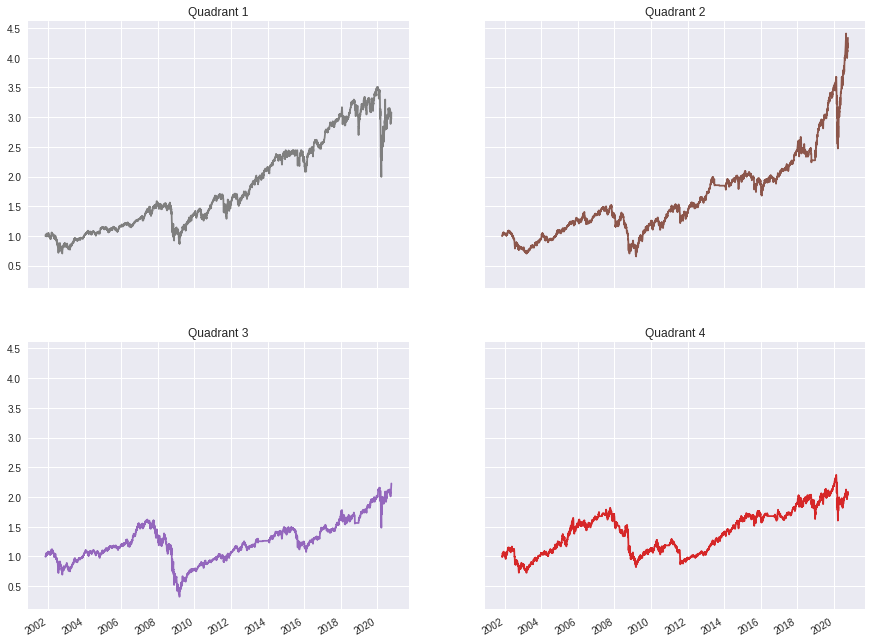

In [198]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12), sharex=True, sharey=True)
daily_cumulative_return['q1'].plot(ax=axes[0, 0], color='tab:grey', title='Quadrant 1')
daily_cumulative_return['q2'].plot(ax=axes[0, 1], color='tab:brown', title='Quadrant 2')
daily_cumulative_return['q3'].plot(ax=axes[1, 0], color='tab:purple', title='Quadrant 3')
daily_cumulative_return['q4'].plot(ax=axes[1, 1], color='tab:red', title='Quadrant 4')

In [206]:
sharpe_ratio = np.sqrt(252) * (backtest.mean() / backtest.std())  # assuming risk-free rate is 0
sharpe_ratio

q1    0.393036
q2    0.490954
q3    0.294395
q4    0.300729
dtype: float64

On the whole, it does appear that centrality shift and relative value are useful trading signals for sector ETFs. Intuitively, sub-portfolio Q3 would yield the highest returns of the three (though with a higher risk profile) and this does appear to be the case of as the last trading day. It also has the highest sharpe ratio of each of the portfolios.

In addition, the authors' hypothesis appears to be valid. A centrality shift value might continue to increase despite the ETF already being in a post-peak sell-off state. The inclusion of a relative value measure provides additional information which 'detects the bursting of the bubble'. Therefore, the signals derived from this strategy are particularly useful from a risk management standpoint.

However, in the strategy's current form, no sub-portfolios were unable to avoid drawdowns during the great recession of 2007-2009, or indeed from the during this current period of Covid-19. This shows the key weakness of the strategy - measures of crowding and fundamental value do not adequately capture the prevailing market conditions or, more importantly, macroeconomic trends.

## Part (f)

> Describe three weaknesses in the procedure outlined in this question and suggest an improvement for each.

1. As this strategy rebalances the portfolio on a daily basis, the high number of trades would lead to a significant amount of *commission*. This backtest also does not account for *slippage*, which results in orders being filled at a price that is different than intended. Both of these factors can potentially be resolved by adding a nominal penalty to each transaction (fixed percentage). On a related note, market liquidity risk can lead to a high bid-ask spread - though this is difficult to account for without historical order book data. 


2. The procedure requires the calculation of the covariance matrix. Here, it is approximated as the *sample* covariance matrix. Not only can this lead to estimation errors, it also does not model the *conditional covariance*, which means that forecasted covariances can depend on past covariances. To address this, one might implement a multivariate GARCH model.


3. Only the two largest eigenvectors and their corresponding eigenvalues are used to calculate the centrality score. However, this value seems rather arbitrary. Though there is a point of diminishing returns for how large $K$ should be, a value that is too small may lead to significant information loss. Given that dimensionality is not a big problem with this dataset, one can plot a cumulative sum of the explained variance and pick a $K$ value which corresponds to the "elbow" (the aforementioned point of diminishing returns).  